<a href="https://colab.research.google.com/github/Rudrabha/SS2021-19-08-2021/blob/main/Inpainting_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import Headers**

In [1]:
import os
!pip install wget
import wget
import shutil
import glob
import cv2
import numpy as np
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9672 sha256=f3164d9fd7f8c946af0c985c1251247d10d2784b346472a4da7adad2f47c124f
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [2]:
from torch.utils.data import Dataset, DataLoader
import torch 
from torch import nn
from torch.nn import functional as F
from torch import optim

In [3]:
use_cuda = torch.cuda.is_available()
print('use_cuda: {}'.format(use_cuda))
device = torch.device("cuda" if use_cuda else "cpu")
print("Device to be used : ",device)
!nvidia-smi

use_cuda: True
Device to be used :  cuda
Wed Aug 18 17:38:51 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    26W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                               

**Setting up Data Path**

In [ ]:
#shutil.rmtree("/content/IMAGE_SUPER_RESOLVE_DATA/extracted_data")

In [4]:
parent_folder = "/content/IMAGE_SUPER_RESOLVE_DATA"

if os.path.isdir(parent_folder):
    shutil.rmtree(parent_folder)
os.mkdir(parent_folder)

#Create Folder to download Raw Data
raw_data_folder = os.path.join(parent_folder,"raw_data")
extracted_data_folder = os.path.join(parent_folder,"extracted_data")

if not os.path.isdir(raw_data_folder):
    os.mkdir(raw_data_folder)

if not os.path.isdir(extracted_data_folder):
    os.mkdir(extracted_data_folder)

image_data_folder = os.path.join(extracted_data_folder, "images")

**Downloading Data**

In [5]:
dataset_link = "https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz"
raw_data = os.path.join(raw_data_folder, "images.tar.gz")
print("Downloading Data")
wget.download(dataset_link, raw_data)
print("Downloading Done")

**Extracting the Data**

In [6]:
shutil.unpack_archive(raw_data, extracted_data_folder)

**Listing the Dataset Features**

In [7]:
def get_image_address(image_data_folder):
    image_address_list = []
    image_address_list = glob.glob(os.path.join(image_data_folder, "*.jpg"))
    print("Number of Files : ", len(image_address_list))
    for img_addr in image_address_list:
        try :
            img = cv2.imread(img_addr)
            x = img.shape
        except :
            image_address_list.remove(img_addr)
            os.remove(img_addr)
        
    print("Number of Files after removing : ", len(image_address_list))

    return image_address_list

**MODULE_1 : Data Loader**

In [30]:
class DataGenerator(Dataset):
	
    def __init__(self, image_list):
        self.files = image_list

        

    def __len__(self):
        return len(self.files)
        

    def __getitem__(self,idx):

        #print(files[idx])
        img = cv2.imread(self.files[idx])
        high_res_img = cv2.resize(img,(512,512))

        start_row = random.randint(0, high_res_img.shape[0]-128)
        start_col = random.randint(0, high_res_img.shape[1]-128)

        input_image = high_res_img.copy()
        input_image[start_row:start_row+128, start_col:start_col+128] = 0 # Randomly creating a 128x128 black spot on the image

        high_res_img = np.transpose(high_res_img, (2, 0, 1))/255.
        input_image = np.transpose(input_image, (2, 0, 1))/255.
        return torch.FloatTensor(high_res_img), torch.FloatTensor(input_image)
		
	
def load_data(image_list, batch_size=32, num_workers=10, shuffle=True):

    dataset = DataGenerator(image_list)
    data_loader = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers, shuffle=shuffle)

    return data_loader

**Checking the dataloader**

In [31]:
parent_folder = "/content/IMAGE_SUPER_RESOLVE_DATA"
extracted_data_folder = os.path.join(parent_folder, "extracted_data")
image_data_folder = os.path.join(extracted_data_folder, "images")
image_address_list = get_image_address(image_data_folder)
random.shuffle(image_address_list)

train_img_addr_list = image_address_list[:int(0.7*len(image_address_list))]
train_loader = load_data(train_img_addr_list, batch_size=1, num_workers=2, shuffle=True)
check = iter(train_loader)



Number of Files :  7384
Number of Files after removing :  7384


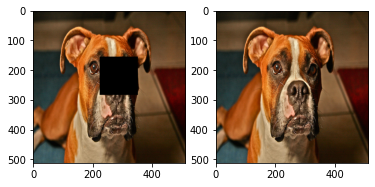

In [40]:
GT, input_img = next(check)
input_img = input_img.numpy()[0]
GT = GT.numpy()[0]

input_img = np.transpose(input_img, (1, 2, 0))
GT = np.transpose(GT, (1, 2, 0))

input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)
GT = cv2.cvtColor(GT, cv2.COLOR_BGR2RGB)

f, axarr = plt.subplots(1,2)
axarr[0].imshow(input_img)
axarr[1].imshow(GT)

**MODULE 2 : Model Creation**

**Conv2D**

In [9]:
class Conv2d(nn.Module):
    def __init__(self, cin, cout, kernel_size, stride, padding, residual=False, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.conv_block = nn.Sequential(
                            nn.Conv2d(cin, cout, kernel_size, stride, padding),
                            nn.BatchNorm2d(cout)
                            )
        self.act = nn.ReLU()
        self.residual = residual

    def forward(self, x):
        out = self.conv_block(x)
        if self.residual:
            out += x
        return self.act(out)

**Conv2D-T**

In [10]:
class Conv2dTranspose(nn.Module):
    def __init__(self, cin, cout, kernel_size, stride, padding, output_padding=0, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.conv_block = nn.Sequential(
                            nn.ConvTranspose2d(cin, cout, kernel_size, stride, padding, output_padding),
                            nn.BatchNorm2d(cout)
                            )
        self.act = nn.ReLU()

    def forward(self, x):
        out = self.conv_block(x)
        return self.act(out)

**Model**

In [11]:
class Image_Super_Resolve(nn.Module):
    def __init__(self):
        super(Image_Super_Resolve, self).__init__()

        self.image_encoder = nn.Sequential(
            Conv2d(3, 4, kernel_size=3, stride=1, padding=1),
            
            Conv2d(4, 8, kernel_size=3, stride=1, padding=1),
            Conv2d(8, 8, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(8, 8, kernel_size=3, stride=1, padding=1, residual=True),
            
            Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
            Conv2d(16, 16, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(16, 16, kernel_size=3, stride=1, padding=1, residual=True),
            
            Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            Conv2d(32, 32, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(32, 32, kernel_size=3, stride=1, padding=1, residual=True),      
            )
        self.image_decoder = nn.Sequential(

            # Conv2dTranspose(32, 32, kernel_size=3, stride=2, padding=1, output_padding=1),

            # Conv2dTranspose(32, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            Conv2d(32, 32, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(32, 32, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(32, 3, kernel_size=3, stride=1, padding=1),
            )
        
    def forward(self, face_image):

        #print("Shape : ",face_image.shape)
        face_embedding = self.image_encoder(face_image)
        # print("Shape : ",face_embedding.shape)
        decoded_face = self.image_decoder(face_embedding)
        decoded_face += face_image

        decoded_face = torch.sigmoid(decoded_face)
        # print("Shape : ",decoded_face.shape)
        return decoded_face


**Code to check the model shape**

In [12]:
model = Image_Super_Resolve()
data = torch.rand(2, 3, 512, 512)
print(data.shape)
decoded_data = model.forward(data)
print (decoded_data.shape)

torch.Size([2, 3, 512, 512])
torch.Size([2, 3, 512, 512])


In [13]:
class PSNR:
    """Peak Signal to Noise Ratio
    img1 and img2 have range [0, 255]"""

    def __init__(self):
        self.name = "PSNR"

    @staticmethod
    def __call__(img1, img2):
        mse = torch.mean((img1 - img2) ** 2)
        return 20 * torch.log10(255.0 / torch.sqrt(mse))


**MODULE 3 : Training**

**TRAIN EPOCH**

In [14]:
def train_epoch(train_loader, model, optimizer, epoch):

    progress_bar = tqdm(enumerate(train_loader))
    total_loss = 0.0
    for step, (high_res_img, low_res_img) in progress_bar:

        try :
            if high_res_img is None and low_res_img is None:
                continue
            model.train()
            high_res_img = high_res_img.to(device)
            low_res_img = low_res_img.to(device)

            optimizer.zero_grad()

            pred_img = model.forward(low_res_img)

            mse = nn.MSELoss()
            psnr = PSNR()

            mse_loss = mse(pred_img, high_res_img)
            psnr_loss = psnr(pred_img*255.0, high_res_img*255.0)

            loss = mse_loss

            # print(loss)
            loss.backward()
            optimizer.step()

            progress_bar.set_description(
            "Epoch : {} Training Loss : {} ".format(epoch, loss))
        except:
            continue

    return model, optimizer

**Validation Loop**

In [15]:
def val_epoch(val_loader, model, optimizer, epoch):

    progress_bar = tqdm(enumerate(val_loader))
    total_loss = 0.0
    for step, (high_res_img, low_res_img) in progress_bar:

        try :
            if high_res_img is None and low_res_img is None:
                continue

            high_res_img = high_res_img.to(device)
            low_res_img = low_res_img.to(device)

            mse = nn.MSELoss()
            psnr = PSNR()

            model.eval()
            pred_img = model.forward(low_res_img)

            mse_loss = mse(pred_img, high_res_img)
            psnr_loss = psnr(pred_img*255.0, high_res_img*255.0)

            loss = mse_loss

            progress_bar.set_description(
            "Epoch : {} Validation Loss : {} ".format(epoch, loss))
        except :
            continue


**Test Loop**

In [16]:
def test_epoch(test_loader, model, optimizer, epoch):

    progress_bar = tqdm(enumerate(test_loader))
    total_loss = 0.0

    no_img_to_write = 10
    inference_folder = "/content/IMAGE_SUPER_RESOLVE_DATA/inference_data"
    if not os.path.isdir(inference_folder):
        os.mkdir(inference_folder)

    if not os.path.isdir(os.path.join(inference_folder, str(epoch))):
        os.mkdir(os.path.join(inference_folder, str(epoch)))

    for step, (high_res_img, low_res_img) in progress_bar:

        try:
            if high_res_img is None and low_res_img is None:
                continue

            high_res_img = high_res_img.to(device)
            low_res_img = low_res_img.to(device)

            mse = nn.MSELoss()
            l1 = nn.L1Loss()
            psnr = PSNR()

            model.eval()
            pred_img = model.forward(low_res_img)

            #mse_loss = mse(pred_img, high_res_img)
            #psnr_loss = psnr(pred_img*255.0, high_res_img*255.0)
            l1_loss = l1(pred_img, high_res_img)

            loss = l1_loss

            progress_bar.set_description(
            "Epoch : {} Test Loss : {} ".format(epoch, loss))

            if(step < no_img_to_write):

                p_img = pred_img.cpu().numpy().transpose(0, 2, 3, 1) * 255
                gt_img = high_res_img.cpu().numpy().transpose(0, 2, 3, 1) * 255
                inp_img = low_res_img.cpu().numpy().transpose(0, 2, 3, 1) * 255

                cv2.imwrite(os.path.join(inference_folder, str(epoch),
                        "img_"+str(step)+"_pred.jpg"), p_img[0])
                cv2.imwrite(os.path.join(inference_folder, str(epoch),
                        "img_"+str(step)+"_gt.jpg"), gt_img[0])
                cv2.imwrite(os.path.join(inference_folder, str(epoch),
                        "img_"+str(step)+"_inp.jpg"), inp_img[0])
        except :
            continue

**Code to **

In [20]:
def train_val_test(train_loader, val_loader, test_loader, model, optimizer, n_epoch, resume):

    checkpoint_path = "/content/IMAGE_SUPER_RESOLVE_DATA/checkpoint.pt"

    epoch = 0
    if resume:
        model, optimizer, epoch = load_ckp(
            checkpoint_path, model, optimizer)

    while 1:
        model, optimizer = train_epoch(train_loader, model, optimizer, epoch)
        #checkpoint = {'epoch': epoch+1, 'state_dict': model.state_dict(),
        #              'optimizer': optimizer.state_dict()}
        #save_ckp(checkpoint, checkpoint_path)
        #print("Checkpoint Saved")
        #model, optimizer, epoch = load_ckp(checkpoint_path, model, optimizer)
        #print("Checkpoint Loaded")
        with torch.no_grad():
            val_epoch(val_loader, model, optimizer, epoch)
            test_epoch(test_loader, model, optimizer, epoch)

In [18]:
def main():

    parent_folder = "/content/IMAGE_SUPER_RESOLVE_DATA"
    extracted_data_folder = os.path.join(parent_folder, "extracted_data")
    image_data_folder = os.path.join(extracted_data_folder, "images")
    image_address_list = get_image_address(image_data_folder)
    random.shuffle(image_address_list)

    train_img_addr_list = image_address_list[:int(0.7*len(image_address_list))]
    val_img_addr_list = image_address_list[len(train_img_addr_list):int(
        len(train_img_addr_list) + 0.2*len(image_address_list))]
    test_img_addr_list = image_address_list[len(
        train_img_addr_list) + len(val_img_addr_list):]

    print("Total Number of Images : ", len(image_address_list))
    print("Train : {} Val : {} Test : {}".format(
        len(train_img_addr_list), len(val_img_addr_list), len(test_img_addr_list)))

    train_loader = load_data(
        train_img_addr_list, batch_size=2, num_workers=2, shuffle=True)
    val_loader = load_data(val_img_addr_list, batch_size=2,
                           num_workers=10, shuffle=True)
    test_loader = load_data(
        test_img_addr_list, batch_size=1, num_workers=10, shuffle=False)

    model = Image_Super_Resolve()
    model = model.to(device)
    optimizer = optim.Adam(
        [p for p in model.parameters() if p.requires_grad], lr=0.01)
    n_epoch = 100
    resume = False
    train_val_test(train_loader, val_loader, test_loader,
                   model, optimizer, n_epoch, resume)

In [19]:
main()

Number of Files :  7390
Number of Files after removing :  7384
Total Number of Images :  7384
Train : 5168 Val : 1476 Test : 740


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Epoch : 0 Training Loss : 0.06547795236110687 : : 89it [00:31,  2.84it/s]


RuntimeError: ignored